In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy.stats import norm
from scipy.special import softmax
from sklearn.preprocessing import normalize

from vae import *
from ans import code_rans, decode_rans

In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

orig_x_train = x_train
orig_x_test = x_test

# Scale to be between [-1, 1]
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

print(x_train.shape)

mnist_digits = x_train
mnist_digits = np.expand_dims(mnist_digits, -1)

(60000, 28, 28)


[-1.         -1.         -1.         -0.3647059   0.88235295  0.9843137
  0.9843137  -0.06666667 -0.8039216  -1.        ]


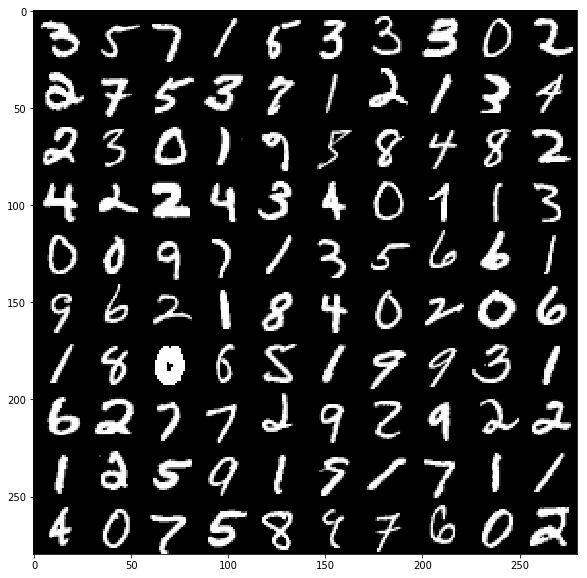

In [3]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = digit
    
    plt.figure(figsize=(max(n, 3), max(n, 3)))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    

print(mnist_digits[0, 14, 10:20].reshape(10))
display_digits(mnist_digits)

In [4]:
enc = keras.models.load_model('vae-encoder')
dec = keras.models.load_model('vae-decoder')

In [5]:
q_dist = enc.predict(x_test)
q_mu, q_log_var = q_dist[0], q_dist[1]
print(q_mu.shape, q_log_var.shape)
q_mu[0:10], q_log_var[:10]

(10000, 128) (10000, 128)


(array([[-3.46727073e-01, -1.07753932e-01, -3.82630378e-01, ...,
         -6.91604167e-02, -1.88155010e-01,  3.26996148e-02],
        [ 9.85599577e-01, -1.35158658e-01, -3.33151251e-01, ...,
          2.13724032e-01,  1.59626558e-01, -3.97524804e-01],
        [ 1.25171110e-01, -1.53349610e-02, -2.23633945e-02, ...,
         -8.65759049e-03,  4.17858735e-03,  1.58701241e-01],
        ...,
        [-1.74369104e-03, -2.38065086e-02, -1.94003403e-01, ...,
          7.37305880e-02,  1.12097815e-01, -2.77072191e-04],
        [ 2.64526069e-01,  1.06723458e-01, -1.54134572e-01, ...,
          2.70983398e-01, -1.30881175e-01, -4.39489186e-01],
        [-4.97794837e-01,  3.84944957e-03, -2.07664996e-01, ...,
          4.63909060e-02,  1.52585402e-01, -8.00140798e-02]], dtype=float32),
 array([[-8.860754 , -4.895995 , -8.717974 , ..., -7.216066 , -8.667343 ,
         -8.025097 ],
        [-9.41813  , -5.113341 , -9.232627 , ..., -7.305365 , -9.311801 ,
         -8.927202 ],
        [-8.48037  , -

In [7]:
stack = np.random.randint(low=0, high=(1 << 32) - 1, size=256, dtype=np.uint32).tolist()
stack.append(int(np.random.randint(low=(1 << 32), high=(1 << 63))))

stack, y = decode_y(stack, q_mu[0], q_log_var[0])

quant_y = quantize_y(y)
yp = dequantize_y(quant_y)

#q_mu[0], y, quant_y, dequantize_y(quant_y)
all(yp == dequantize_y(quantize_y(yp)))

True

In [9]:
stack = np.random.randint(low=0, high=(1 << 32) - 1, size=256, dtype=np.uint32).tolist()
stack.append(int(np.random.randint(low=(1 << 32), high=(1 << 63))))
stack, y = decode_y(stack, q_mu[0], q_log_var[0])
quant_y = quantize_y(y)
yp = dequantize_y(quant_y)

quant_y = quantize_y(yp)
stack = []
stack = encode_y(quant_y, stack)
stack, ydecode = decode_y(stack, mu=np.zeros(len(quant_y)), log_var=np.zeros(len(quant_y)))

assert all(yp == ydecode)

In [10]:
np.random.seed(0)
x = np.random.randint(0, 100, size=(4, 4))
print(x)
maxval = np.amax(x, axis=-1).reshape(-1, 1)
print(maxval)
x = np.where(x == maxval, x + 100, x)
x

[[44 47 64 67]
 [67  9 83 21]
 [36 87 70 88]
 [88 12 58 65]]
[[67]
 [83]
 [88]
 [88]]


array([[ 44,  47,  64, 167],
       [ 67,   9, 183,  21],
       [ 36,  87,  70, 188],
       [188,  12,  58,  65]])

In [11]:
index = 0
n_components = 3
quant_bits = 16
output = dec.predict(ydecode.reshape(1,-1))
output.shape

m = output[index, :, :, :n_components]
invs = output[index, :, :, n_components:2*n_components]
logit_weights = output[index, :, :, 2*n_components:3*n_components]
weights = softmax(logit_weights[:, :, :], axis=-1)
pvals = compute_mixture(m, invs, weights, n_components)

def quantize_distribution(pvals, quant_bits=16):
    ''' Translate probability distribution into a frequency distribution 
        ensuring each bucket has at least one count 
        pvals - N x 256 numpy array of 256 pixel values
    '''
    # Add +1 to each zero bin to ensure non-zero probability
    freqs = np.round(pvals * (1 << quant_bits))
    freqs = np.where(freqs == 0, freqs + 1, freqs)
   
    # Re-adjust frequencies so that it adds up to exactly 2^quant_bits
    # (Shave it off from largest bin)
    adjustment = (1 << quant_bits) - np.sum(freqs, axis=-1)
    maxval_index = np.argmax(freqs, axis=-1)
    for i in range(len(adjustment)):
        freqs[i, maxval_index[i]] += adjustment[i]

    return freqs
    

pvals = pvals.reshape(-1, pvals.shape[-1])
freqs = quantize_distribution(pvals)
freqs

array([[6.5281e+04, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [6.5281e+04, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [6.5281e+04, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       ...,
       [6.5281e+04, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [6.5281e+04, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [6.5281e+04, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00]])

In [22]:
def encode_x(data, freqs, stack):
    ''' Encodes the (flattened) image using ANS
    
        data - flattened data
        freqs - frequencies for the flattened data 
        stack - existing stack of coded symbols
    '''
    assert len(data) == freqs.shape[0], (data.shape, freqs.shape)
    for i in range(len(data)):
        freq = freqs[i]
        alphabet = list(range(len(freq)))
        cdf = np.cumsum(freq)
        cdf = np.insert(cdf, 0, 0).astype(np.uint64)
        stack = code_rans(data[i], stack, alphabet, freq, cdf)
        
    return stack

data = orig_x_test[0]
data = data.reshape(-1).tolist()
stack = []
stack = encode_x(data, freqs, stack)

def decode_x(freqs, stack):
    ''' Decodes the flattened image using ANS
    
        freqs - frequencies for the flattened data 
        stack - existing stack of coded symbols
    '''
    result = []
    for i in reversed(range(freqs.shape[0])):
        freq = freqs[i]
        alphabet = list(range(len(freq)))
        cdf = np.cumsum(freq)
        cdf = np.insert(cdf, 0, 0).astype(np.uint64)
        stack, s = decode_rans(stack, alphabet, freq, cdf)
        result.append(s)
        
    return stack, list(reversed(result))

stack, recon_data = decode_x(freqs, stack)
recon_data == data

True

In [13]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = digit
    
    plt.figure(figsize=(max(n, 3), max(n, 3)))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

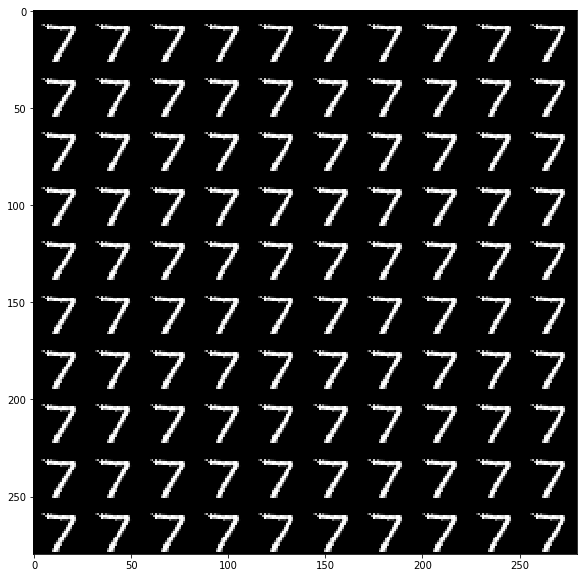

In [14]:
num_samples = 1
#output = dec.predict(np.random.normal(size=(num_samples, 128)))
img = np.zeros(shape=(num_samples, 1, 28, 28))
for index in range(num_samples):
    m = output[index, :, :, :n_components]
    invs = output[index, :, :, n_components:2*n_components]
    logit_weights = output[index, :, :, 2*n_components:3*n_components]
    weights = softmax(logit_weights[:, :, :], axis=-1)
    
    # Compute pixel distribution and sample
    pvals = compute_mixture(m, invs, weights, n_components)
    for i in range(img[0].shape[1]):
        for j in range(img[0].shape[1]):
            ps = pvals[i, j, :]
            ps /= (np.sum(ps) + 1e-6)
            img[index, 0, i, j] = np.argmax(np.random.multinomial(1, ps))
            
display_digits(img)

In [15]:
1 / (2 ** 16) * (2 ** 16)

1.0